# Imports

In [54]:
#Imports
import numpy as np
import pandas as pd

#Settings for string legibility
pd.set_option('display.max_rows', 50)
pd.options.display.max_colwidth = 500
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:90% !important; }</style>'))

import matplotlib.pyplot as plt
import seaborn as sns
#Plot output
%matplotlib inline
plt.rcParams['figure.figsize'] = [18,10]
plt.rcParams['figure.dpi'] = 150
%config InlineBackend.figure_format = 'svg'

#Booking.com colorscheme RGBA
blue_d = np.array([0/256, 53/256, 128/256, 1])
blue_l = np.array([0/256, 159/256, 227/256, 1])
yellow = np.array([254/256, 186/256, 2/256, 1])
grey = np.array([102/256, 102/256, 102/256, 1])
white = np.array([242/256, 246/256, 250/256, 1])

#Booking.com palette (Hex)
c15 = ['#003580', '#009fe3', '#feba02', '#D9958D', '#00C4CC', '#77A0D9', '#8CB811', '#F57D00', '#4A8594', '#D52685', '#CE1126', '#553A99', '#D9958D','#0EA013', '#8283FA']

#Booking.com settings Seaborn
sns.set(rc={'axes.facecolor':'#f2f6fa', 'figure.facecolor':'#f2f6fa'})
sns.set_palette(sns.color_palette(c15))

#Quality of life
from IPython.display import display
pd.set_option('colheader_justify', 'left')
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
%precision %.2f
%precision 2

import warnings
warnings.filterwarnings('ignore')

#Importing the auxiliar and preprocessing librarys 
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, f1_score
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, MiniBatchKMeans

from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression, ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LinearRegression, Ridge, SGDRegressor
from sklearn.svm import SVC, LinearSVC, SVR, LinearSVR
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, RandomTreesEmbedding, ExtraTreesRegressor

from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
import lightgbm as lgb





from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

# Data

In [2]:
df = pd.read_csv('Booking_features.csv')

In [3]:
df.head(3)

,Team,Country,R_word_count,R_char_count,R_word_density,R_punc_count,Job Description - Cleaned,C_word_count,C_char_count,C_word_density,...,Leadership,Legal & Public Affairs,Marketing & Communications,People,Product,Security & Infrastructure,Score,Score_median,Score_max,Category
0,Engineering,United Kingdom,962,5727,0.17,161,booking.com long ago book trip see eiffel tower stroll new york iconic madison avenue feel sand toe copacabana beach simply matter tap smartphone fact booking.com make easy everyone experience world world might feel little farther away right busy prepare world ready travel across office worldwide continue innovate solve complex challenge travel technology plan excite development lie ahead strategic long-term investment believe future travel opening new career opportunity strong impact missio...,613,4360,0.14,...,10,2,2,11,9,10,114,9.00,18,Engineer
1,Design & User Experience,Netherlands,687,3757,0.18,77,booking.com data drive decision technology core innovation everywhere company datasets line code a/b test thrill first night new place excitement next morning friend make journey take sight see food sample product partner people make easy everyone experience world look ux copywriter join write team marketing support business travel department close-knit write community make around 15 writer creative copywriter ux writer collaborate across product integrate marketing campaign goal deliver sea...,401,2740,0.15,...,6,1,10,6,9,0,73,5.50,10,UX
2,Finance,Netherlands,833,5203,0.16,106,booking.com global treasury team look treasury risk management professional join grow team treasury risk specialist responsible perform financial analysis operating process relate identification quantification management reporting credit counterparty liquidity treasury risk typology attach book evolve business model strategic initiative third party relationship individual form integral part treasury risk team reporting treasury manager function prefer candidate accustom work fast pace enviro...,562,4099,0.14,...,6,4,6,7,7,4,94,6.50,14,Specialist


# Initial predictions - Only TEXT

### Encoding Categorical Column Team

In [4]:
encoder = LabelEncoder()
y = encoder.fit_transform(df.loc[:,['Team']])
#X = df.loc[:,['Job Description - Cleaned']].values
X = df['Job Description - Cleaned'].values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [6]:
#X_train
y_train = y_train.reshape(-1,1)
#type(X_test)
y_test = y_test.reshape(-1,1)


In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(522,)
(522, 1)
(131,)
(131, 1)


### Vectorizing tfidf

In [360]:
'''# Instantiate the vectorizer
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 2),
    token_pattern=r'\w{2,}',
    max_df=.75,
    min_df=0.01
    )

# fit and transform on it the training features
word_vectorizer.fit(X_train)
X_train = word_vectorizer.transform(X_train)

#transform the test features to sparse matrix
X_test = word_vectorizer.transform(X_test)'''

"# Instantiate the vectorizer\nword_vectorizer = TfidfVectorizer(\n    sublinear_tf=True,\n    strip_accents='unicode',\n    analyzer='word',\n    ngram_range=(1, 2),\n    token_pattern=r'\\w{2,}',\n    max_df=.75,\n    min_df=0.01\n    )\n\n# fit and transform on it the training features\nword_vectorizer.fit(X_train)\nX_train = word_vectorizer.transform(X_train)\n\n#transform the test features to sparse matrix\nX_test = word_vectorizer.transform(X_test)"

In [8]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

In [9]:
#Make LSA features
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 2),
    token_pattern=r'\w{2,}',
    max_df=.75,
    min_df=0.01
    )

X_train = word_vectorizer.fit_transform(X_train)
X_test = word_vectorizer.transform(X_test)

svd = TruncatedSVD(n_components=150)
normalizer = Normalizer(copy=False)

lsa = make_pipeline(svd, normalizer)

X_train = lsa.fit_transform(X_train)
X_test = lsa.transform(X_test)

#X_train = pd.DataFrame(lsa.fit_transform(X_train))
#X_test = pd.DataFrame(lsa.transform(X_test))

Explained variance of the SVD: 78%


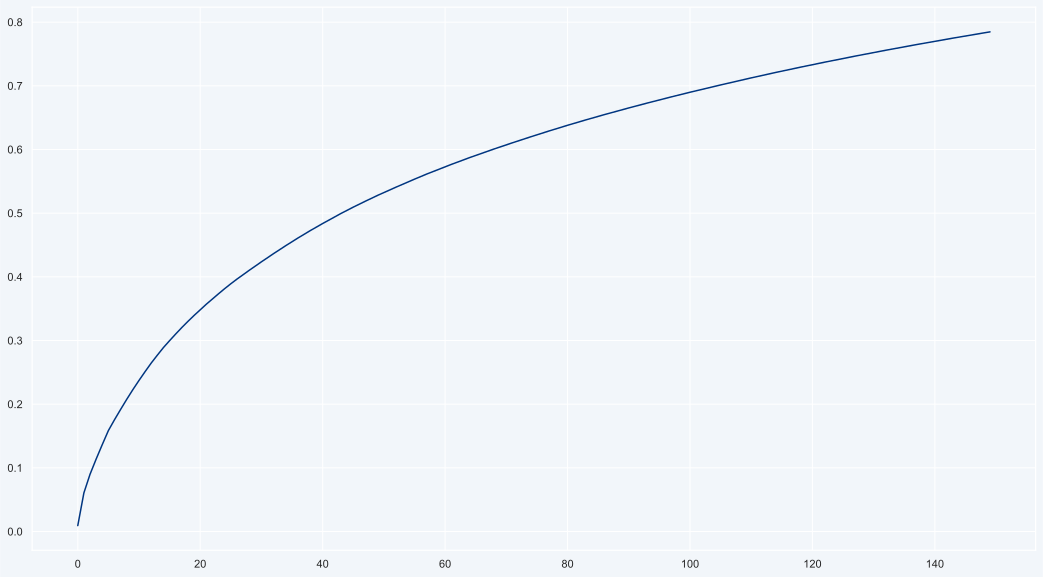

In [10]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))
print('Explained variance of the SVD: {}%'.format(int(svd.explained_variance_ratio_.sum() * 100)))

https://vitalv.github.io/projects/doc-clustering-topic-modeling.html

## Logistic Regression

In [374]:
lr = LogisticRegression(random_state = 42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Logistic Regression Accuracy Score: {0:0.4f}'.format(accuracy_score(y_pred, y_test)))

Logistic Regression Accuracy Score: 0.8168


### Random Forest

In [375]:
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('Random Forest Accuracy Score: {0:0.4f}'.format(accuracy_score(y_pred, y_test)))

Random Forest Accuracy Score: 0.8092


### KNN

In [376]:
knn = KNeighborsClassifier(n_neighbors = 13, metric = 'minkowski', n_jobs=-1, p = 2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('KNN Accuracy Score: {0:0.4f}'.format(accuracy_score(y_pred, y_test)))

KNN Accuracy Score: 0.8473


In [11]:
'''# instantiate classifier with default hyperparameters with kernel=rbf, C=1.0 and gamma=auto
knn=KNeighborsClassifier() 

# declare parameters for hyperparameter tuning
parameters = [ {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}
              ]

knn_grid_search = GridSearchCV(estimator = knn,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

knn_grid_search.fit(X_train, y_train);

print('Estimator chosen by the gridsearch :',knn_grid_search.best_estimator_)
print('GridSearch CV score on test set: {0:0.4f}'.format(knn_grid_search.score(X_test, y_test)))'''

"# instantiate classifier with default hyperparameters with kernel=rbf, C=1.0 and gamma=auto\nknn=KNeighborsClassifier() \n\n# declare parameters for hyperparameter tuning\nparameters = [ {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}\n              ]\n\nknn_grid_search = GridSearchCV(estimator = knn,  \n                           param_grid = parameters,\n                           scoring = 'accuracy',\n                           cv = 5,\n                           verbose=0)\n\nknn_grid_search.fit(X_train, y_train);\n\nprint('Estimator chosen by the gridsearch :',knn_grid_search.best_estimator_)\nprint('GridSearch CV score on test set: {0:0.4f}'.format(knn_grid_search.score(X_test, y_test)))"

### SVM

In [133]:
s = SVC(kernel='linear',C=10,random_state=42)
s.fit(X_train, y_train)
y_pred = s.predict(X_test)
print('SVM Accuracy Score: {0:0.4f}'.format(accuracy_score(y_pred, y_test)))

TypeError: 'SVC' object is not callable

In [13]:
'''# instantiate classifier with default hyperparameters with kernel=rbf, C=1.0 and gamma=auto
svc=SVC() 

# declare parameters for hyperparameter tuning
parameters = [ {'C':[1, 10, 100], 'kernel':['linear']},
               {'C':[1, 10, 100], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3]},
               {'C':[1, 10, 100], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03]} 
              ]

svm_grid_search = GridSearchCV(estimator = svc,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

svm_grid_search.fit(X_train, y_train);

print('Estimator chosen by the gridsearch :',svm_grid_search.best_estimator_)
print('GridSearch CV score on test set: {0:0.4f}'.format(svm_grid_search.score(X_test, y_test)))'''

"# instantiate classifier with default hyperparameters with kernel=rbf, C=1.0 and gamma=auto\nsvc=SVC() \n\n# declare parameters for hyperparameter tuning\nparameters = [ {'C':[1, 10, 100], 'kernel':['linear']},\n               {'C':[1, 10, 100], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3]},\n               {'C':[1, 10, 100], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03]} \n              ]\n\nsvm_grid_search = GridSearchCV(estimator = svc,  \n                           param_grid = parameters,\n                           scoring = 'accuracy',\n                           cv = 5,\n                           verbose=0)\n\nsvm_grid_search.fit(X_train, y_train);\n\nprint('Estimator chosen by the gridsearch :',svm_grid_search.best_estimator_)\nprint('GridSearch CV score on test set: {0:0.4f}'.format(svm_grid_search.score(X_test, y_test)))"


Comments

Our original model test accuracy is 0.8626 while GridSearch CV score on test-set is 0.8626.

So, GridSearch CV helps to identify the parameters that will improve the performance for this particular model.

Here, we should not confuse best_score_ attribute of grid_search with the score method on the test-set.

The score method on the test-set gives the generalization performance of the model. Using the score method, we employ a model trained on the whole training set.

The best_score_ attribute gives the mean cross-validation accuracy, with cross-validation performed on the training set.



***

In [11]:
kfold = StratifiedKFold(n_splits=5)

In [12]:
SEED = 42

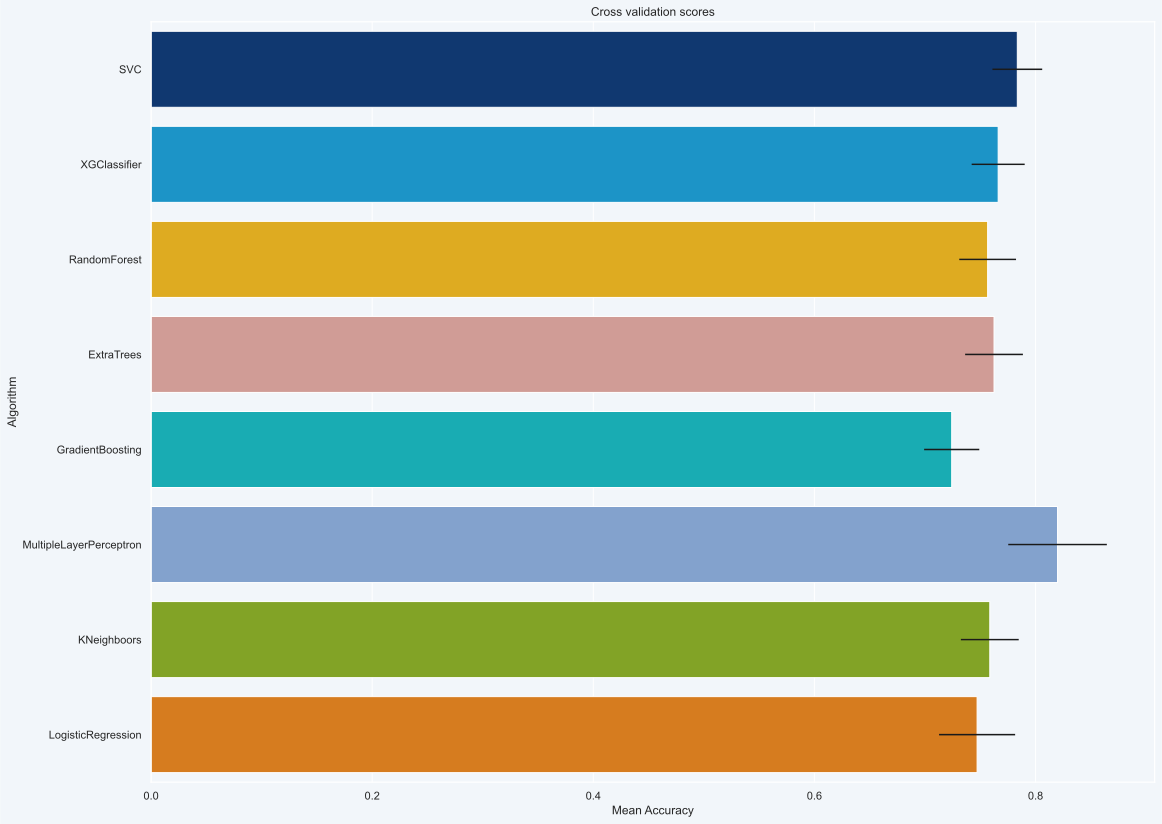

In [13]:
# Modeling step Test differents algorithms 
classifiers = []
classifiers.append(SVC(random_state=SEED))
classifiers.append(XGBClassifier(n_estimators=100, random_state=SEED))
classifiers.append(RandomForestClassifier(random_state=SEED))
classifiers.append(ExtraTreesClassifier(random_state=SEED))
classifiers.append(GradientBoostingClassifier(random_state=SEED))
classifiers.append(MLPClassifier(random_state=SEED))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = SEED))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = 'accuracy', cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans':cv_means,'CrossValerrors': cv_std,'Algorithm':['SVC','XGClassifier',
'RandomForest','ExtraTrees','GradientBoosting','MultipleLayerPerceptron','KNeighboors','LogisticRegression']})

fig = plt.figure(figsize=(18,14))

g = sns.barplot('CrossValMeans','Algorithm',data = cv_res, orient = 'h',**{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross validation scores')

## Hyperparameter tunning for best models

In [71]:
from sklearn.svm import SVC

In [72]:
#SVC Classifier
SVC = SVC(probability=True,random_state=SEED)

#Search grid for optimal parameters
svc_param_grid = { 'C': [1, 10, 100], 
                    'kernel': ['linear', 'rbf'],
                    'gamma':[0.01, 0.001]
                    }

gsSVC = GridSearchCV(SVC,param_grid = svc_param_grid, cv=kfold, scoring='accuracy', n_jobs= -1, verbose = 1)

gsSVC.fit(X_train,y_train)

gsSVC_best = gsSVC.best_estimator_

#Best score
gsSVC.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


0.8083882783882783

In [73]:
gsSVC.best_params_

{'C': 1, 'gamma': 0.01, 'kernel': 'linear'}

In [285]:
'''#XGBoostClassifier
XGBC = XGBClassifier(random_state=SEED)

#Search grid for optimal parameters
xgbc_param_grid = { 'n_estimators': [100],
                    'learning_rate': [0.1],
                    'booster': ['gbtree'],
                    'gamma': [0, 1],
                    'reg_alpha': [1],
                    'reg_lambda': [0.5],
                    'base_score': [1]
                  }

gsXGBC = GridSearchCV(XGBC,param_grid = xgbc_param_grid, cv=kfold, scoring='accuracy', n_jobs= -1, verbose = 1)

gsXGBC.fit(X_train,y_train)

gsXGBC_best = gsXGBC.best_estimator_

#Best score
gsXGBC.best_score_'''

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[20:08:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7623992673992674

In [23]:
#XGBoostClassifier
XGBC = XGBClassifier(random_state=SEED)

#Search grid for optimal parameters
xgbc_param_grid = { 'n_estimators': [100, 500],
                    'learning_rate': [0.01,0.1],
                    'booster': ['gbtree'],
                    'gamma': [0, 0.5, 1],
                    'reg_alpha': [0,0.5, 1],
                    'reg_lambda': [0,0.5,5],
                    'base_score': [0.2,0.5, 1]
                  }

gsXGBC = GridSearchCV(XGBC,param_grid = xgbc_param_grid, cv=kfold, scoring='accuracy', n_jobs= -1, verbose = 1)

gsXGBC.fit(X_train,y_train)

gsXGBC_best = gsXGBC.best_estimator_

#Best score
gsXGBC.best_score_

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[22:43:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7853113553113553

In [24]:
gsXGBC.best_params_

{'base_score': 0.20,
 'booster': 'gbtree',
 'gamma': 0,
 'learning_rate': 0.10,
 'n_estimators': 500,
 'reg_alpha': 0,
 'reg_lambda': 5}

In [41]:
#Random Forest 
RFC = ExtraTreesClassifier()

## Search grid for optimal parameters
rfc_param_grid = {'max_depth': [None],
                  'max_features': [100, 1000],
                  'min_samples_split': [2],
                  'min_samples_leaf': [1],
                  'bootstrap': [False],
                  'n_estimators' :[100,300,500, 1000],
                  'criterion': ['gini', 'entropy']
                 }

gsRFC = GridSearchCV(RFC,param_grid = rfc_param_grid, cv=kfold, scoring='accuracy', n_jobs= -1, verbose = 1)

gsRFC.fit(X_train,y_train)

gsRFC_best = gsRFC.best_estimator_

#Best score
gsRFC.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


0.7834798534798535

In [42]:
gsRFC.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 100,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [39]:
#ExtraTrees 
ETC = ExtraTreesClassifier()

## Search grid for optimal parameters
etc_param_grid = {'max_depth': [None],
                  'max_features': [100, 1000],
                  'min_samples_split': [2],
                  'min_samples_leaf': [1],
                  'bootstrap': [False],
                  'n_estimators' :[100,300,500, 1000],
                  'criterion': ['gini', 'entropy']
                 }

gsETC = GridSearchCV(ETC,param_grid = etc_param_grid, cv=kfold, scoring='accuracy', n_jobs= -1, verbose = 1)

gsETC.fit(X_train,y_train)

ETC_best = gsETC.best_estimator_

#Best score
gsETC.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


0.7796703296703297

In [40]:
gsETC.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 100,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [177]:
'''#ExtraTrees 
ETC = ExtraTreesClassifier()

## Search grid for optimal parameters
etc_param_grid = {'max_depth': [None],
                  'max_features': [1, 3, 10],
                  'min_samples_split': [2, 3, 10],
                  'min_samples_leaf': [1, 3, 10],
                  'bootstrap': [False],
                  'n_estimators' :[100,300],
                  'criterion': ['gini']
                 }

gsETC = GridSearchCV(ETC,param_grid = etc_param_grid, cv=kfold, scoring='accuracy', n_jobs= -1, verbose = 1)

gsETC.fit(X_train,y_train)

ETC_best = gsETC.best_estimator_

#Best score
gsETC.best_score_'''

"#ExtraTrees \nETC = ExtraTreesClassifier()\n\n## Search grid for optimal parameters\netc_param_grid = {'max_depth': [None],\n                  'max_features': [1, 3, 10],\n                  'min_samples_split': [2, 3, 10],\n                  'min_samples_leaf': [1, 3, 10],\n                  'bootstrap': [False],\n                  'n_estimators' :[100,300],\n                  'criterion': ['gini']\n                 }\n\ngsETC = GridSearchCV(ETC,param_grid = etc_param_grid, cv=kfold, scoring='accuracy', n_jobs= -1, verbose = 1)\n\ngsETC.fit(X_train,y_train)\n\nETC_best = gsETC.best_estimator_\n\n#Best score\ngsETC.best_score_"

In [292]:
'''#MultiLayer Perceptron 
MLPC = MLPClassifier()

## Search grid for optimal parameters
mlpc_param_grid = { 'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
                    'activation': ['relu'],
                    'solver': ['adam'],
                    'alpha': [0.05],
                    'learning_rate': ['adaptive']
                  }

gsMLPC = GridSearchCV(MLPC,param_grid = mlpc_param_grid, cv=kfold, scoring='accuracy', n_jobs= -1, verbose = 1)

gsMLPC.fit(X_train,y_train)

MLPC_best = gsETC.best_estimator_

#Best score
gsMLPC.best_score_'''

Fitting 5 folds for each of 3 candidates, totalling 15 fits


0.8121611721611721

In [50]:
#MultiLayer Perceptron 
MLPC = MLPClassifier()

## Search grid for optimal parameters
mlpc_param_grid = { 'hidden_layer_sizes': [(50,50,50), (100,)],
                    'max_iter': [50, 100, 150, 500],
                    'activation': ['relu'],
                    'solver': ['lbfgs', 'adam'],
                    'alpha': [0.0001, 0.05],
                    'learning_rate': ['adaptive']
                  }

gsMLPC = GridSearchCV(MLPC,param_grid = mlpc_param_grid, cv=kfold, scoring='accuracy', n_jobs= -1, verbose = 1)

gsMLPC.fit(X_train,y_train)

MLPC_best = gsETC.best_estimator_

#Best score
gsMLPC.best_score_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


0.8141208791208789

In [51]:
gsMLPC.best_params_

{'activation': 'relu',
 'alpha': 0.05,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'adaptive',
 'max_iter': 500,
 'solver': 'adam'}

In [52]:
#K-Nearest Neighbors
KNN = KNeighborsClassifier()

## Search grid for optimal parameters
knn_param_grid = {  'n_neighbors':list(range(1,30,1)),
                    'leaf_size':list(range(1,50,1))
                 }

gsKNN = GridSearchCV(KNN,param_grid = knn_param_grid, cv=kfold, scoring='accuracy', n_jobs= -1, verbose = 1)

gsKNN.fit(X_train,y_train)

KNN_best = gsETC.best_estimator_

#Best score
gsKNN.best_score_

Fitting 5 folds for each of 1421 candidates, totalling 7105 fits


0.7681684981684982

In [53]:
gsKNN.best_params_

{'leaf_size': 1, 'n_neighbors': 1}

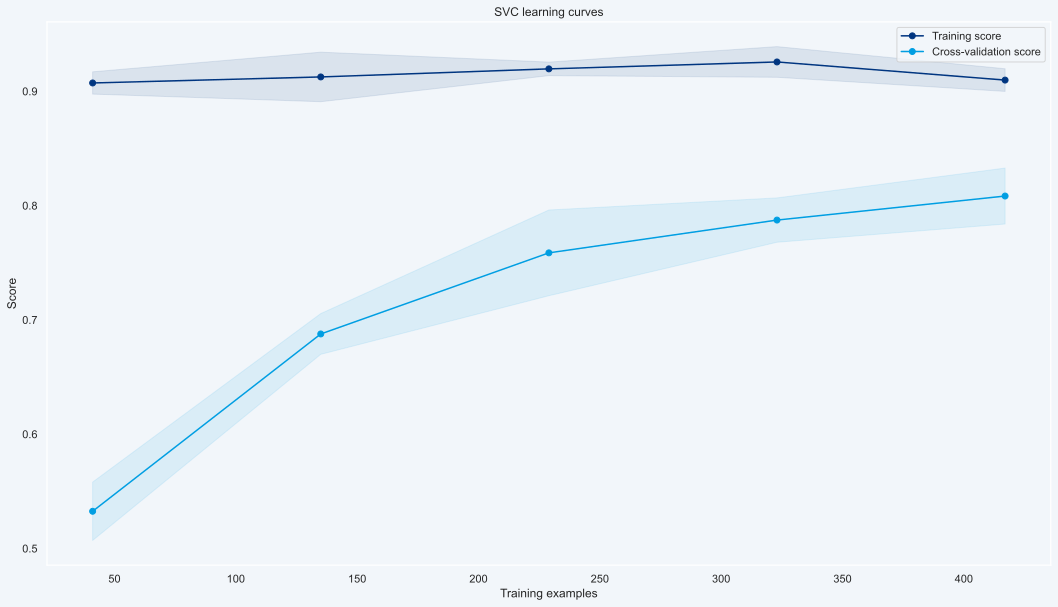

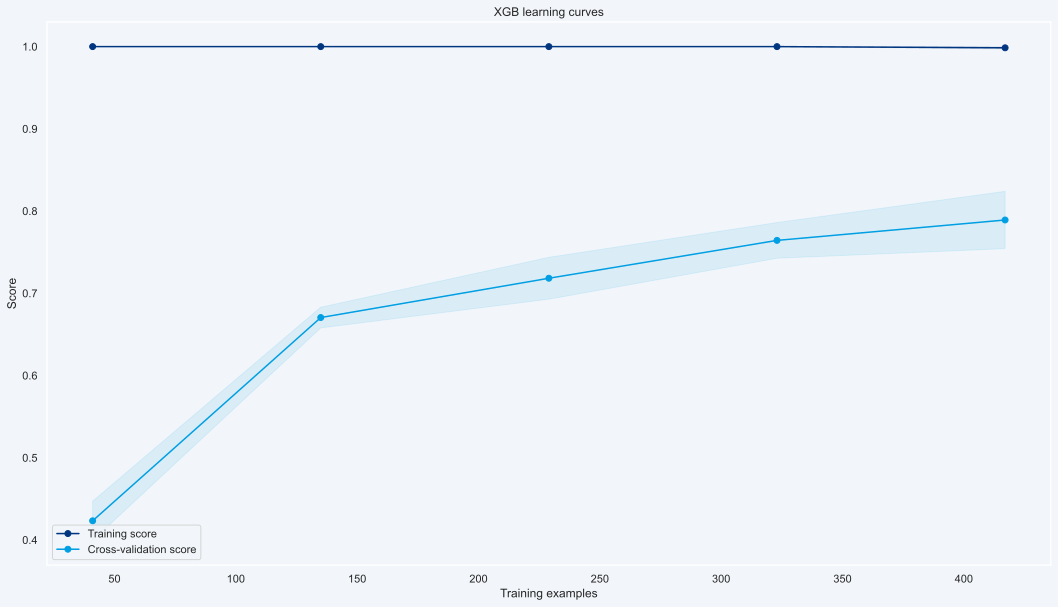

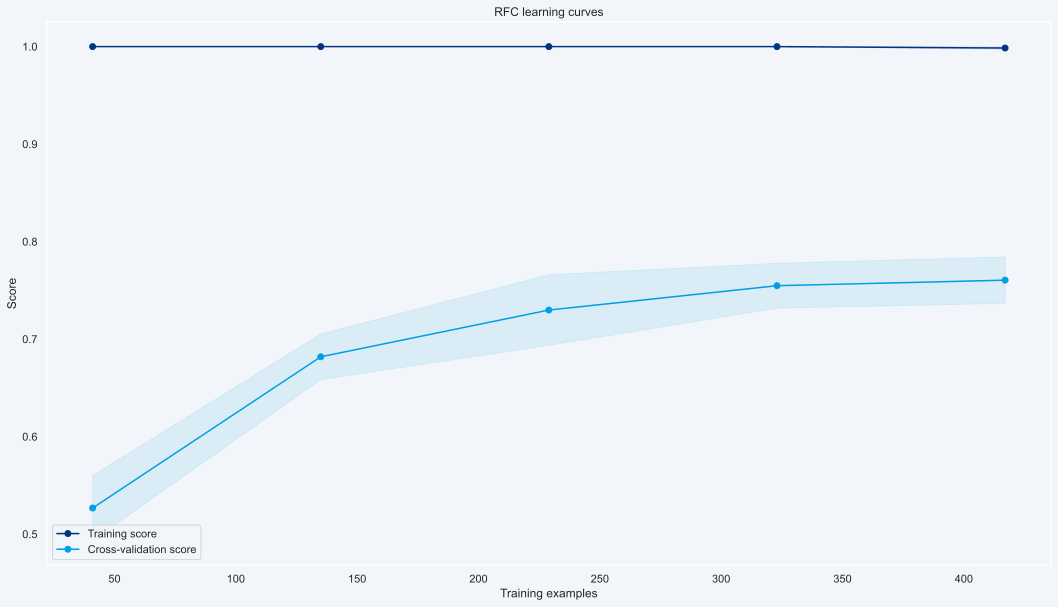

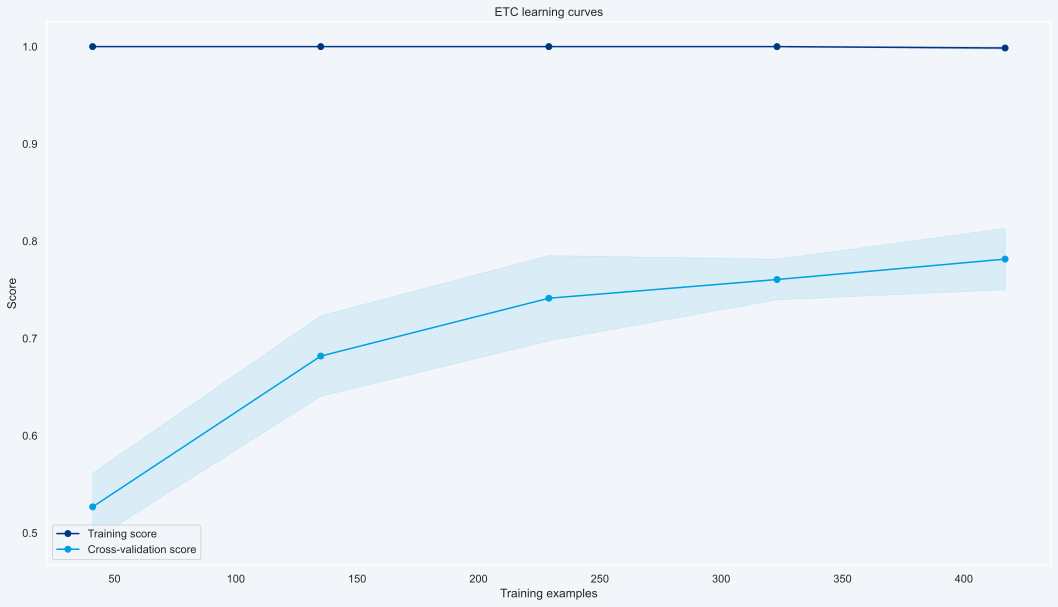

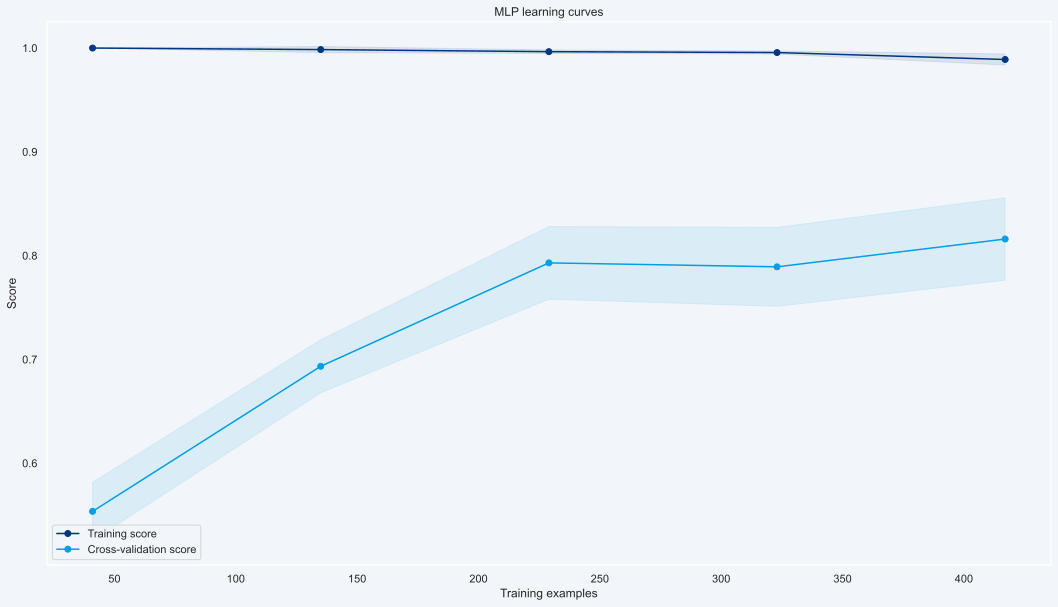

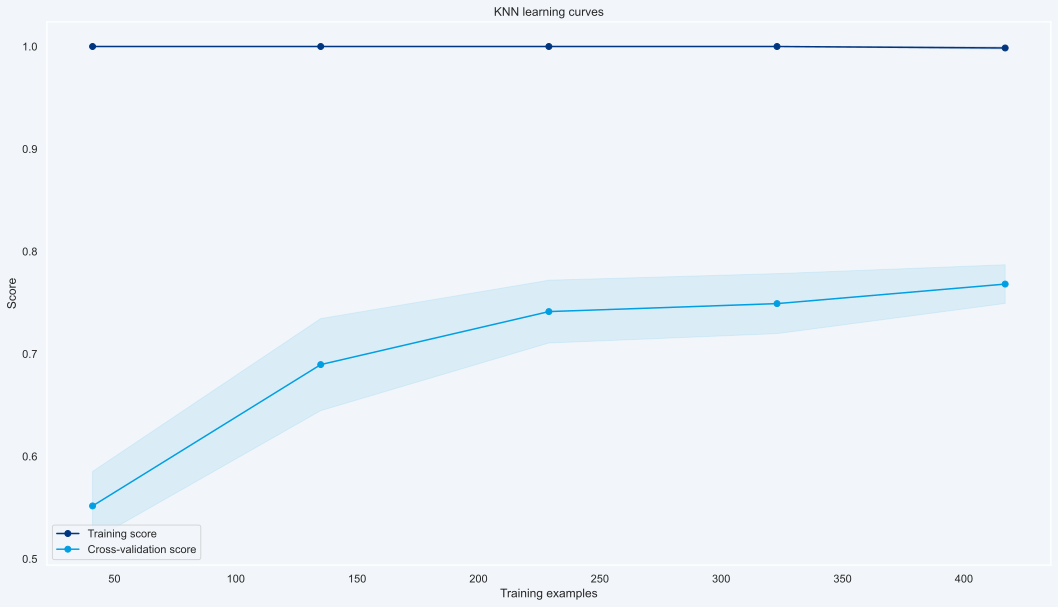

In [57]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    '''Generate a simple plot of the test and training learning curve'''
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color=blue_d)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color=blue_l)
    plt.plot(train_sizes, train_scores_mean, 'o-', color=blue_d,
             label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color=blue_l,
             label='Cross-validation score')

    plt.legend(loc='best')
    return plt

g = plot_learning_curve(gsSVC.best_estimator_,'SVC learning curves',X_train,y_train,cv=kfold)
g = plot_learning_curve(gsXGBC.best_estimator_,'XGB learning curves',X_train,y_train,cv=kfold)
g = plot_learning_curve(gsRFC.best_estimator_,'RFC learning curves',X_train,y_train,cv=kfold)
g = plot_learning_curve(gsETC.best_estimator_,'ETC learning curves',X_train,y_train,cv=kfold)
g = plot_learning_curve(gsMLPC.best_estimator_,'MLP learning curves',X_train,y_train,cv=kfold)
g = plot_learning_curve(gsKNN.best_estimator_,'KNN learning curves',X_train,y_train,cv=kfold)

In [74]:
votingC = VotingClassifier(estimators=[ ('SVC', gsSVC_best),
                                        ('XGBC', gsXGBC_best),
                                        ('RFC', gsRFC_best),
                                        ('ETC', ETC_best),
                                        ('MLP', MLPC_best),
                                        ('KNN',KNN_best)], 
                                        voting='soft', 
                                        n_jobs=4)

votingC = votingC.fit(X_train, y_train)

In [75]:
y_pred = votingC.predict(X_test)

In [76]:
predicted = encoder.inverse_transform(y_pred)
true = encoder.inverse_transform(y_test).reshape(1,-1).flatten()

In [77]:
df_results = pd.DataFrame({'True Values': true, 'Predicted Values': predicted})
df_results

,True Values,Predicted Values
0,Customer Service,Customer Service
1,Engineering,Engineering
2,Design & User Experience,Design & User Experience
3,People,People
4,Engineering,Engineering
...,...,...
126,Engineering,Engineering
127,Leadership,Leadership
128,People,People
129,Design & User Experience,Design & User Experience


In [78]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.95      0.85        21
           1       1.00      0.80      0.89         5
           2       0.75      0.75      0.75         4
           3       0.88      1.00      0.93         7
           4       0.86      0.88      0.87        34
           5       0.00      0.00      0.00         2
           6       0.75      0.60      0.67         5
           7       1.00      1.00      1.00         1
           8       1.00      0.86      0.92         7
           9       0.50      1.00      0.67         1
          10       0.75      0.50      0.60         6
          11       0.91      0.91      0.91        22
          12       1.00      0.62      0.77         8
          13       0.80      1.00      0.89         8

    accuracy                           0.85       131
   macro avg       0.78      0.78      0.77       131
weighted avg       0.84      0.85      0.84       131

0.8473282442748091


In [ ]:
def plot_dim_red(model, features, labels, n_components=2):
    
    # Creation of the model
    if (model == 'PCA'):
        mod = PCA(n_components=n_components)
        title = 'PCA decomposition'  # for the plot
        
    elif (model == 'TSNE'):
        mod = TSNE(n_components=2)
        title = 't-SNE decomposition' 

    else:
        return 'Error'
    
    # Fit and transform the features
    principal_components = mod.fit_transform(features)
    
    # Put them into a dataframe
    df_features = pd.DataFrame(data=principal_components,
                     columns=['PC1', 'PC2'])
    
    # Now we have to paste each row's label and its meaning
    # Convert labels array to df
    df_labels = pd.DataFrame(data=labels,
                             columns=['label'])
    
    df_full = pd.concat([df_features, df_labels], axis=1)
    df_full['label'] = df_full['label'].astype(str)

    # Get labels name
    category_names = {
        '0': 'business intelligence',
        '1': 'data analyst',
        '2': 'data engineer',
        '3': 'data scientist',
        '4': 'full stack developer'
    }
    
    # And map labels
    df_full['label_name'] = df_full['label']
    df_full = df_full.replace({'label_name':category_names})

    # Plot
    plt.figure(figsize=(10,10))
    sns.set_palette('hls', 5)
    sns.scatterplot(x='PC1',
                    y='PC2',
                    hue='label_name', 
                    data=df_full,
                    #palette=['red', 'orange', 'darkgreen', 'blue', 'purple'],
                    alpha=.7).set_title(title);

In [ ]:
plot_dim_red('PCA', features=X_train.toarray(), labels=y, n_components=2)

In [ ]:
plot_dim_red('TSNE', features=X_train.toarray(), labels=y, n_components=2)

# Features

In [ ]:
print(df.dtypes)
print('\nShape:',df.shape)

In [ ]:
print(df_team.dtypes)
print('\nShape:',df_team.shape)

In [ ]:
frames = [df.drop(columns=['Job Description', 'Location','Team_kmeans']),df_team.drop(columns=['Job Title', 'Job Description - Cleaned'])]
df_total = pd.concat(frames, axis=1).reset_index(drop=True)

In [ ]:
df_total.head(1)

In [ ]:
print(df_total.dtypes)
print('\nShape:',df_total.shape)

### Reducing cardinality

Both Job Title and Country have a high amount of non-numeric unique values. In order to make use of these columns in our model we need to reduce cardinality and encode them to numeric values.

In [ ]:
df_total['Job Title'].nunique() #Number of unique values

In [ ]:
#Create simple dictionary of categories
d = {
    'Manager': ['Manager'],
    'Data Scientist': ['Scientist'],
    'Data Analyst': ['Analyst'],
    'ML': ['Machine'],
    'Engineer': ['Engineer'],
    'Developer': ['Developer'],
    'Accounts': ['Account'],
    'Recruiter': ['Recruiter'],
    'UX': ['UX'],
    'Specialist': ['Specialist'],
    'Sales': ['Commercial'],
    'Lead': ['Lead'],
    'Customer Relations': ['Customer'],
    'Finance': ['Business']
    }

#Create Category column with default value of Other
df_total['Category'] = 'Other'

#Loop through dictionary
for k, v in d.items():
    pat = '' ''.join(v)
    mask = df_total['Job Title'].str.contains(pat, case=False)

    df_total.loc[mask, 'Category'] = k #Replace value with key from dictionary if substring occurs

In [ ]:
df_total['Category'].nunique() #Number of unique values after replacing values

In [ ]:
df_total = df_total.drop(columns='Job Title') #Drop Job Title column as it's replaced by Category

In [ ]:
df_total.dtypes

In [ ]:
df_total['Country'].nunique()

In [ ]:
countries = df_total['Country'].value_counts().index.tolist()

df_total['Country'] = np.where(df_total['Country'].isin(countries[:14]), df_total['Country'], 'Other')

In [ ]:
df_total['Country'].nunique()

## Declaring X / y

In [ ]:
X = df_total.iloc[:,1:]
y = df_total.iloc[:, 0]

In [ ]:
X

### Label Encoding

In [ ]:
enc_le = LabelEncoder()
y = enc_le.fit_transform(y)

### One-Hot Encoding

In [ ]:
enc_ohe = OneHotEncoder(sparse=False)
X_1=X
columns=['Category', 'Country']

for col in columns:

   df_cat=X[[col]].append(X[[col]])
   enc_ohe.fit(df_cat)

   temp = enc_ohe.transform(X[[col]])

   temp=pd.DataFrame(temp,columns=[(col+"_"+str(i)) for i in df_cat[col]
        .value_counts().index])


   temp=temp.set_index(X.index.values)

   X=pd.concat([X_1,temp],axis=1)
X.drop(columns=columns, inplace=True)

### Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

### TF-IDF Vectorization

In [ ]:
# Instantiate the vectorizer
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 2),
    token_pattern=r'\w{2,}',
    max_df=.75,
    min_df=0.01,
    )

# fit and transform on it the training features
word_vectorizer.fit(X_train['Job Description - Cleaned'])
X_train_word_features = word_vectorizer.transform(X_train['Job Description - Cleaned'])

#transform the test features to sparse matrix
X_test_word_features = word_vectorizer.transform(X_test['Job Description - Cleaned'])

In [ ]:
df1 = pd.DataFrame(X_train_word_features.toarray(), columns=word_vectorizer.get_feature_names()) #Create temporary df from sparse matrix of TF-IDF vectors
df1.index = X_train.index #Set index to be equal
X_train = pd.concat([X_train, df1], axis=1) #Contact dataframes
X_train.drop(columns='Job Description - Cleaned', inplace=True) #Drop original text column

df2 = pd.DataFrame(X_test_word_features.toarray(), columns=word_vectorizer.get_feature_names())
df2.index = X_test.index
X_test = pd.concat([X_test, df2], axis=1) #Contact dataframes
X_test.drop(columns='Job Description - Cleaned', inplace=True) #Drop original text column

print(X_train.shape)
print(X_test.shape)

***

### Scaling

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
X_train.iloc[:,:24] = sc.fit_transform(X_train.iloc[:,:24])
X_test.iloc[:,:24] = sc.fit_transform(X_test.iloc[:,:24])

In [ ]:
X_train.iloc[:,:24]

In [ ]:
X_train

In [ ]:
# collection to store results 
from collections import defaultdict

# models to test
from sklearn.linear_model import PassiveAggressiveClassifier 
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegressionCV     


# insistent our storage 
bench_mark = defaultdict(list)

# get the transformer params
tfidf_params = dict(sublinear_tf= True, 
                       min_df = 5, 
                       norm= 'l2', 
                       ngram_range= (1,2), 
                       stop_words ='english')

# list of models we would like to complete 
models = [
PassiveAggressiveClassifier(C=1e-1,max_iter=1e3,  tol=1e3), 
RidgeClassifierCV(scoring='roc_auc', cv=10),
LogisticRegressionCV(cv=5,solver='saga',scoring='accuracy', random_state=1, n_jobs=-1),
SGDClassifier(loss='log', random_state=1, max_iter=101),
 ]

# train, test and store each model 
for model in models:

    # our pipeline is changed to accept model
    clf = Pipeline(steps=[
        ('features', TfidfVectorizer(**tfidf_params)),
        ('model', model) #just model not model() as we have done that in models list
    ])

    clf.fit(X_train,y_train)
     score = clf.score(X_test,y_test)

    model_name = clf.named_steps['model'].__class__.__name__ # hack to get name

    model_params = clf.named_steps['model']. get_params()


    print(f'{model_name} Scored: {score:.3f}\n')

    bench_mark['model_name'].append(model_name)
    bench_mark['score'].append(score)
    bench_mark['model'].append(clf)
    bench_mark['used_params'].append(model_params)

# in the end, place the bench_mark to DataFrame
models_df = pd.DataFrame(bench_mark)

# now you have the trained modes in DataFrame, their scores and parameters. 
#You can access and use any model.

logistic_reg = models_df[models_df['model_name']=='LogisticRegressionCV']['model'].iloc[0]

y_preds = logistic_reg.predict(X_test)


***

***

### Modelling

In [ ]:
encoder = LabelEncoder()
y = encoder.fit_transform(df['Team'])
#X = df.loc[:,['Job Description - Cleaned']]
X = df['Job Description - Cleaned']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

### Vectorizing tfidf

In [ ]:
# Instantiate the vectorizer
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 2),
    token_pattern=r'\w{2,}',
    max_df=.75,
    min_df=0.01
    )

# fit and transform on it the training features
word_vectorizer.fit(X_train)
X_train = word_vectorizer.transform(X_train)

#transform the test features to sparse matrix
X_test = word_vectorizer.transform(X_test)

In [ ]:
#Creating cross validation strategy with shuffle
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=0).get_n_splits(X_train.toarray())
    rmse = np.sqrt(-cross_val_score(model, X_train.toarray(), y_train, scoring='neg_mean_squared_error', cv = kf))
    return(rmse)

#### Lasso

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=0))

#### Elastic Net Regression


In [ ]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=0))

#### Kernel Ridge Regression

In [ ]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

#### Gradient Boosting

In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =0)

#### XGBoost

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =0, nthread = -1,
                             verbosity = 0)

#### LightGBM

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,
                              verbose_eval = -1)

### Model Scores

In [ ]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

### Average Base Model Score

In [ ]:
class AverageModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    #Define clones of original models to fit the data
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        #Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Predictions for cloned models and get average
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [ ]:
averaged_models = AverageModels(models = (lasso, ENet, GBoost, KRR))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

### Stacking Average Base Models

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    #Fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        
        # Train cloned base models then create out-of-fold predictions to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        #Train the cloned meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Predictions of all base models on test data and use the averaged predictions as 
    #meta-features for the final prediction
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)



In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
stacked_averaged_models.fit(X_train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(X_train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(X_test.values))
print(rmsle(y_train, stacked_train_pred))

In [ ]:
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))
print(rmsle(y_train, xgb_train_pred))

In [ ]:
model_lgb.fit(X_train, y_train)
lgb_train_pred = model_lgb.predict(X_train)
lgb_pred = np.expm1(model_lgb.predict(X_test.values))
print(rmsle(y_train, lgb_train_pred))

In [ ]:
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

In [ ]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble

***

# Try only TFIDT with esemble

***

In [ ]:
lr = LogisticRegression(random_state = 42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)# Use accuracy_score function to get the accuracy
print('Logistic Regression Accuracy Score: {0:0.4f}'.format(accuracy_score(y_pred, y_test)))

### Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('Random Forest Accuracy Score: {0:0.4f}'.format(accuracy_score(y_pred, y_test)))

In [ ]:
Feature_score=zip(X_train.columns, rf.feature_importances_)
for name, score in Feature_score:
   print('{} - {:.4f}'.format(name, (score*1000)))

In [ ]:
df_total

### KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 13, metric = 'minkowski', n_jobs=-1, p = 2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)# Use accuracy_score function to get the accuracy
print('KNN Accuracy Score: {0:0.4f}'.format(accuracy_score(y_pred, y_test)))

### SVM

In [ ]:
s = svm.SVC(kernel='linear',C=10,random_state=42)
s.fit(X_train, y_train)# predict the labels on validation dataset
y_pred = s.predict(X_test)# Use accuracy_score function to get the accuracy
print('SVM Accuracy Score: {0:0.4f}'.format(accuracy_score(y_pred, y_test)))

In [ ]:
# instantiate classifier with default hyperparameters with kernel=rbf, C=1.0 and gamma=auto
svc=SVC() 

# declare parameters for hyperparameter tuning
parameters = [ {'C':[1, 10, 100], 'kernel':['linear']},
               {'C':[1, 10, 100], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3]},
               {'C':[1, 10, 100], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03]} 
              ]

svm_grid_search = GridSearchCV(estimator = svc,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

svm_grid_search.fit(X_train, y_train);

print('Estimator chosen by the gridsearch :',svm_grid_search.best_estimator_)
print('GridSearch CV score on test set: {0:0.4f}'.format(svm_grid_search.score(X_test, y_test)))

***

### K-Means

In [ ]:
encoder = LabelEncoder()
y = encoder.fit_transform(df['Team'])
#X = df.loc[:,['Job Description - Cleaned']]
X = df['Job Description - Cleaned']

In [ ]:
# Instantiate the vectorizer
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 2),
    token_pattern=r'\w{2,}',
    max_df=.75,
    min_df=0.01
    )

# fit and transform on it the training features
X_tfidf = word_vectorizer.fit_transform(X)

In [ ]:
clusters = MiniBatchKMeans(n_clusters=14, init_size=1024, batch_size=2048, random_state=42).fit_predict(X_tfidf)

In [ ]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=500, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(18, 12))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    ax[0].legend(label_subset)
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(X_tfidf, clusters)

In [ ]:
kmeans = KMeans(n_clusters = 14, n_init = 5)
kmeans.fit(X_tfidf)

In [ ]:
words = word_vectorizer.get_feature_names()

In [ ]:
df['Team_kmeans'] = kmeans.labels_

In [ ]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

In [ ]:
clusters = df.groupby(['Team_kmeans', 'Team']).size()
fig2, ax2 = plt.subplots(figsize = (9, 9))
sns.heatmap(clusters.unstack(level = 'Team'), ax = ax2, cbar=False, cmap = 'Blues')

ax2.set_xlabel('Team', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('Kmeans Cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight('bold')
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight('bold')

# Kmeans clusters

In [ ]:
def get_top_keywords(data, clusters, labels, n_terms):
    df_k = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df_k.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(X_tfidf, clusters, word_vectorizer.get_feature_names(), 10)

***